# Animate the growth of critical lines and caustics
Starting from the example seen in Lecture 7, we will study how critical lines and caustics grow as a function of redshif. The lens redshift is fixed ($z_L=0.3$). The source redshift will be varied between $z_S=0.4$ and $z_S=6$. The result of the simulation will be saved in the movie ```ccandcau.mp4```.

In [1]:
# import the necessary modules. Several new methods have been included in the 
# deflector module to perform caluculations shown in the previous lectures
import deflector
import numpy as np
import matplotlib.pyplot as plt

df=deflector.deflector('data/kappa_gl.fits',True)
a1,a2=df.angle_map()
ka=df.convergence_map()
gamma_1,gamma_2=df.shear_map()
gamma=np.sqrt(gamma_1**2+gamma_2**2)

Now, we need to rescale the convergence and the shear maps to obtain new maps corresponding to each $D_{LS}/D_S$:

In [2]:
from astropy.cosmology import FlatLambdaCDM
from scipy.ndimage import map_coordinates
import matplotlib.animation as animation


#define the cosmological framework
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
#%matplotlib inline

#set the vector of source redshifts
zl=0.3
zs=np.logspace(np.log10(zl+0.1),np.log10(6.0),100)

# compute the distances
dl=cosmo.angular_diameter_distance(zl)
ds=cosmo.angular_diameter_distance(zs)
dls=[]
for i in range(ds.size):
    dls.append(cosmo.angular_diameter_distance_z1z2(zl,zs[i]).value)

# the input convergence maps is normalized to z_s=2.0    
zs_norm=2.0
ds_norm=cosmo.angular_diameter_distance(zs_norm)
dls_norm=cosmo.angular_diameter_distance_z1z2(zl,zs_norm)

# set up the animation writer (matplotlib)
Writer = animation.writers['ffmpeg']
writer = Writer(fps=7, metadata=dict(artist='Me'), bitrate=3600)

# create a figure with two subplots
fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

# set the limits on each couple of axes
ax1.set_xlim([0,512])
ax1.set_ylim([0,512])
ax2.set_xlim([0,512])
ax2.set_ylim([0,512])

# create a template for the two subplots
l, = ax1.plot([], [], ',',color='red')
m, = ax2.plot([], [], ',',color='blue')
z_template = 'z = %.1f'
z_text = ax1.text(0.8, 0.8, '', transform=ax1.transAxes)

# start creating frames by iterating over the redshifts
with writer.saving(fig, "ccandcau.mp4", 100):
    for i in range(ds.size):

        # update the kappa and gamma maps and compute the eigenvalue maps
        kappa_new=ka*ds_norm.value/dls_norm.value*dls[i]/ds[i].value
        gamma_new=gamma*ds_norm.value/dls_norm.value*dls[i]/ds[i].value
        lambdat_new=(1.0-kappa_new-gamma_new)
        lambdar_new=(1.0-kappa_new+gamma_new)
        detA=lambdat_new*lambdar_new
    
        # create the contours
        fig0,ax0=plt.subplots(1,1,figsize=(8,8))
        cs=ax0.contour(detA,levels=[0.0],visible=False)
        contour=cs.collections[0]
        p=contour.get_paths() # p contains the paths of each individual critical line
        sizevs=np.empty(len(p),dtype=int)

        # loop over the vertices in the countour line
        if (sizevs.size > 0):
            x1=[]
            x2=[]
            for j in range(len(p)):
                # for each path, we create two vectors containing the x1 and x2 coordinates of the vertices
                vs = contour.get_paths()[j].vertices 
                sizevs[j]=len(vs)

                for k in range(len(vs)):
                    xx1,xx2=vs[k]
                    x1.append(float(xx1))
                    x2.append(float(xx2))
                    # these are the points we want to map back on the source plane. 
                    # To do that we need to evaluate the deflection angle at their positions
                    # using scipy.ndimage.interpolate.map_coordinates we perform a bi-linear interpolation
            a_1=map_coordinates(a1, [[x2],[x1]],order=1)
            a_2=map_coordinates(a2, [[x2],[x1]],order=1)
        
            # now we can make the mapping using the lens equation:
            y1=x1-a_1[0]
            y2=x2-a_2[0]
            
            # update the frame using the templates defined above
            l.set_data(x1,x2)
            m.set_data(y1,y2)
            z_text.set_text(z_template % (zs[i]))
            
            # grab the frame
            writer.grab_frame()


/Users/massimo/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


# Animate the transformation of a critical line into a caustic
Now, we will study how critical lines are transformed into caustics by means of lens mapping. The set-up of this experiment is as follows:
* our lens is at $z_L=0.3$. We choose to study the mapping of the critical points computed for $z_s=6.0$
* we will map these points back to the source plane
* in other words: we are simulating the scenario where the critical line is an image on the lens plane. We will see how its source would look like if it was at any redshift between $z_L=0.3$ and $z_S=6.0$ 

In [4]:
# set up the animation writer
Writer = animation.writers['ffmpeg']
writer = Writer(fps=7, metadata=dict(artist='Me'), bitrate=3600)

# just one subplot, this time
fig,ax1 = plt.subplots(1,1,figsize=(8,8))

ax1.set_xlim([0,512])
ax1.set_ylim([0,512])

# set up the template
l, = ax1.plot([], [], ',',color='red')
z_template = 'z = %.1f'
z_text = ax1.text(0.8, 0.8, '', transform=ax1.transAxes)

# compute critical points for zs=6.0

kappa_new=ka*ds_norm.value/dls_norm.value*dls[ds.size-1]/ds[ds.size-1].value
gamma_new=gamma*ds_norm.value/dls_norm.value*dls[ds.size-1]/ds[ds.size-1].value
lambdat_new=(1.0-kappa_new-gamma_new)
lambdar_new=(1.0-kappa_new+gamma_new)
detA=lambdat_new*lambdar_new

fig0,ax0=plt.subplots(1,1,figsize=(8,8))
cs=ax0.contour(detA,levels=[0.0],visible=False)
contour=cs.collections[0]
p=contour.get_paths() # p contains the paths of each individual critical line
sizevs=np.empty(len(p),dtype=int)

if (sizevs.size > 0):
    x1=[]
    x2=[]
    for j in range(len(p)):
        # for each path, we create two vectors containing the x1 and x2 coordinates of the vertices
        vs = contour.get_paths()[j].vertices 
        sizevs[j]=len(vs)

        for k in range(len(vs)):
            xx1,xx2=vs[k]
            x1.append(float(xx1))
            x2.append(float(xx2))

# iterate over source redshifts             
with writer.saving(fig, "cc2cau.mp4", 100):
    for i in range(ds.size):
        a_1=map_coordinates(a1, [[x2],[x1]],order=1)*ds_norm.value/dls_norm.value*dls[i]/ds[i].value
        a_2=map_coordinates(a2, [[x2],[x1]],order=1)*ds_norm.value/dls_norm.value*dls[i]/ds[i].value
        
        # now we can make the mapping using the lens equation:
        y1=x1-a_1[0]
        y2=x2-a_2[0]
        l.set_data(y1,y2)
        z_text.set_text(z_template % (zs[i]))
        #t=ax2.annotate(r'$z_s=$'+str(zs[i]),(400,400))
        writer.grab_frame()

# Time delays

The time-delay surface is 

$$ t(\vec\theta) \propto \left[\frac{1}{2}(\vec\theta-\vec\beta)^2-\hat\Psi(\vec\theta)\right] $$

The two terms entering this equations are called the geometrical and the gravitational time delays, respectively. 

In the follwoing example, we reduce the problem to one dimension. Instead of dealing with a time-delay surface, we consider a time-delay function (by simply substituting the vectors $\vec\theta$ and $\vec\beta$ with two scalars. We will change the relative position of source and lens to see how the time-delay function changes.

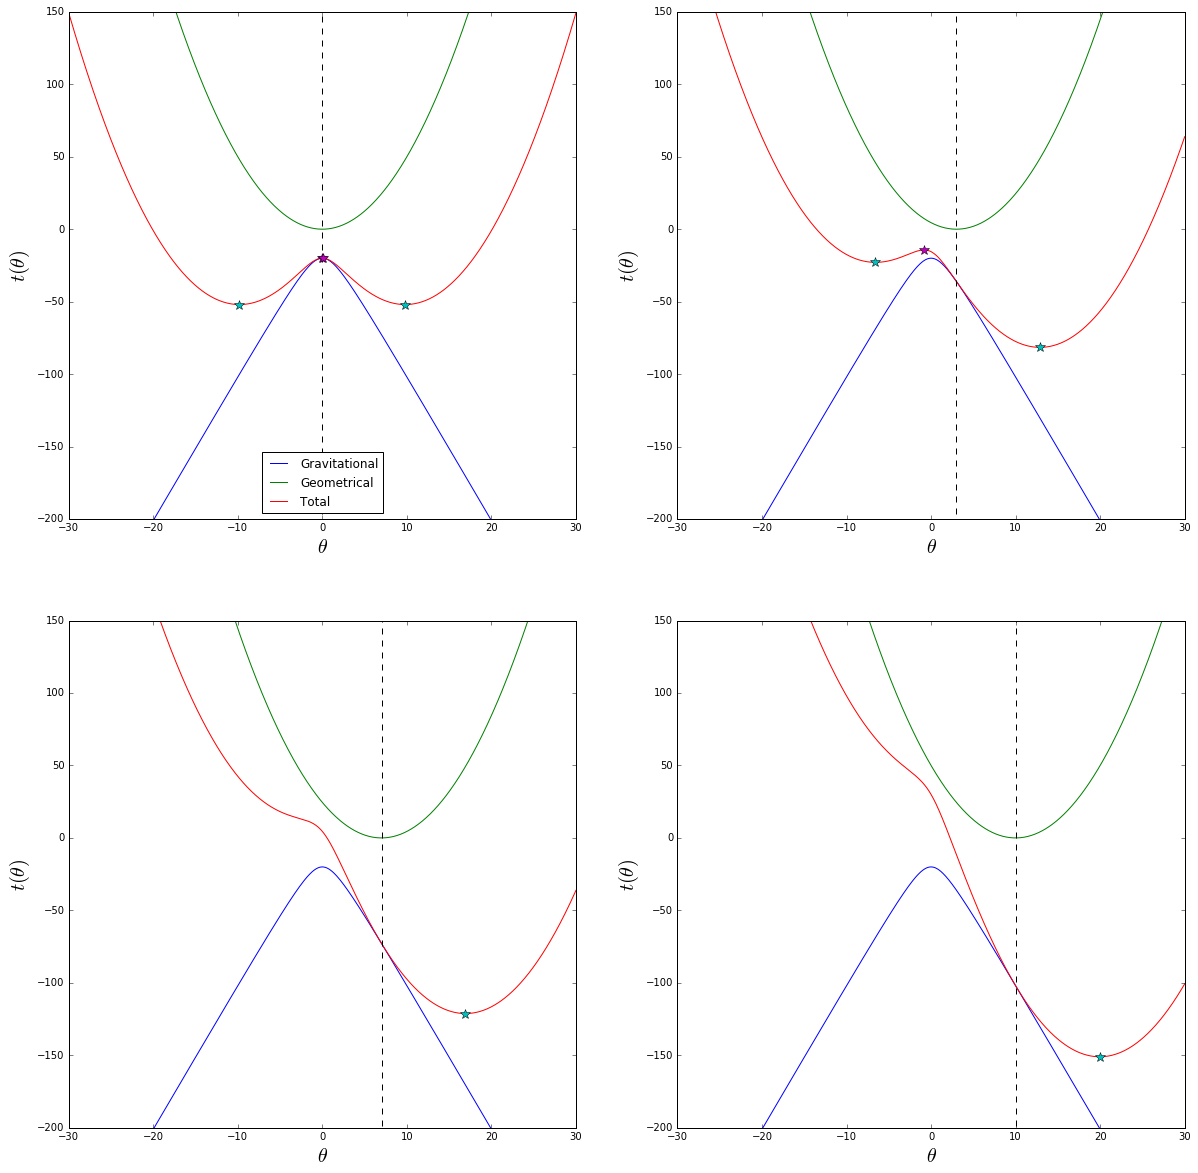

In [5]:
import numpy as np
import matplotlib.pyplot as plt

theta=np.linspace(-30.0,30.0,1000)

def t_grav_func(theta,theta_c=1.0):
    # the lensing potential of a singular-isothermal-sphere
    return -np.sqrt(theta*theta+theta_c*theta_c)*10

theta_c=2.0
t_grav=t_grav_func(theta,theta_c)


def t_geom_func(theta,beta):
    # the geometrical time-delay
    return 0.5*(theta-beta)**2

# the position of the source
beta=[0,3,7,10]

# plot results
%matplotlib inline
fig,ax=plt.subplots(2,2,figsize=(20,20))
for i in range(len(beta)):
    ix=int(i/2)
    iy=i-ix*2
    
    # compute the time-delay as  a function of \theta
    t_geom=t_geom_func(theta,beta[i])

    t_total=t_grav+t_geom

    ax[ix,iy].plot(theta,t_grav,label='Gravitational')
    ax[ix,iy].plot(theta,t_geom,label='Geometrical')
    ax[ix,iy].plot(theta,t_total,label='Total')
    ax[ix,iy].set_xlim([-30,30])
    ax[ix,iy].set_ylim([-200,150])
    x=[beta[i],beta[i]]
    y=[-1500,1000]
    ax[ix,iy].plot(x,y,'--',color='black')
    if (ix == 0 and iy ==0):
        ax[ix,iy].legend(loc='best')

    # find local minima and maxima of the function and mark their positions on the curve 
    i_min= (np.diff(np.sign(np.diff(t_total))) > 0).nonzero()[0] + 1 # local min
    i_max= (np.diff(np.sign(np.diff(t_total))) < 0).nonzero()[0] + 1 # local max
    ax[ix,iy].plot(theta[i_min],t_total[i_min],'*',markersize=10)
    ax[ix,iy].plot(theta[i_max],t_total[i_max],'*',markersize=10)
    ax[ix,iy].set_xlabel(r'$\theta$',fontsize=20)
    ax[ix,iy].set_ylabel(r'$t(\theta)$',fontsize=20)